As part of the effort to demonstrate the Deadtime noise model, we have analyzed TCSPC data aqcuired on MPD 2 on 2024-10-09 (and 10-11).  The MPD was run in normally, but the output from the combined detector was routed to the PicoHarp 330 which was triggered by the QuantumComposer sync output.  The outgoing laser pulse was attenuated using a series of neutral density filters.  This data was originally acquired for the purpose of evaluating afterpulsing on the MPD.

The TCSPC data is binned to 0.1 ns resolution and the approximate (measured) deadtime is 53.1 ns.  It is processed using splines with diadic tree trimming in combination with holdout cross validation to set the number and location of knots in the spline fit.  The retrieved variable is the photon flux.  The spline fits are then evaluated against the data obtained in the lowest flux case (OD 4.0).  The processing was originally written in `Read_TimeTagData.ipynb` in the `pico_device_interface` repository.

Results indicate that fitting using the Deadtime noise model is able to extend the dynamic range of the detector and accurately retreive the flux above 1/deadtime.  While the Mueller noise model performs only slightly worse than the deadtime noise model in the lowest flux case (of fit data -- OD 3.0), significant errors appear the recovered structure in the OD 1.0 case.

*This version is modified by Grant Kirchhoff 02-19-2025 to adjust for paths*

In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import glob
from pathlib import Path

In [2]:
home = str(Path.home())
load_dir = os.path.join(home, 'Documents', 'ARSENL_Local', 'Deadtime Experiments', 'scripts', 'mhayman', 'tcspc_tsoa_pulse')
# load_dir = '/scr/sci/mhayman/tcspc_tsoa_pulse'

In [3]:
sol_file_lst = glob.glob(os.path.join(load_dir,"spline_fit*.nc"))

In [4]:
sol_ds_lst = []
for file in sol_file_lst:
    sol_ds_lst.append(xr.open_dataset(file))
    print(sol_ds_lst[-1].attrs['OD'])

0.0
0.3
1.0
1.0
3.0
3.0


In [5]:
ds_raw = xr.open_dataset(os.path.join(load_dir,"raw_histogram_data.nc"), decode_times=False)

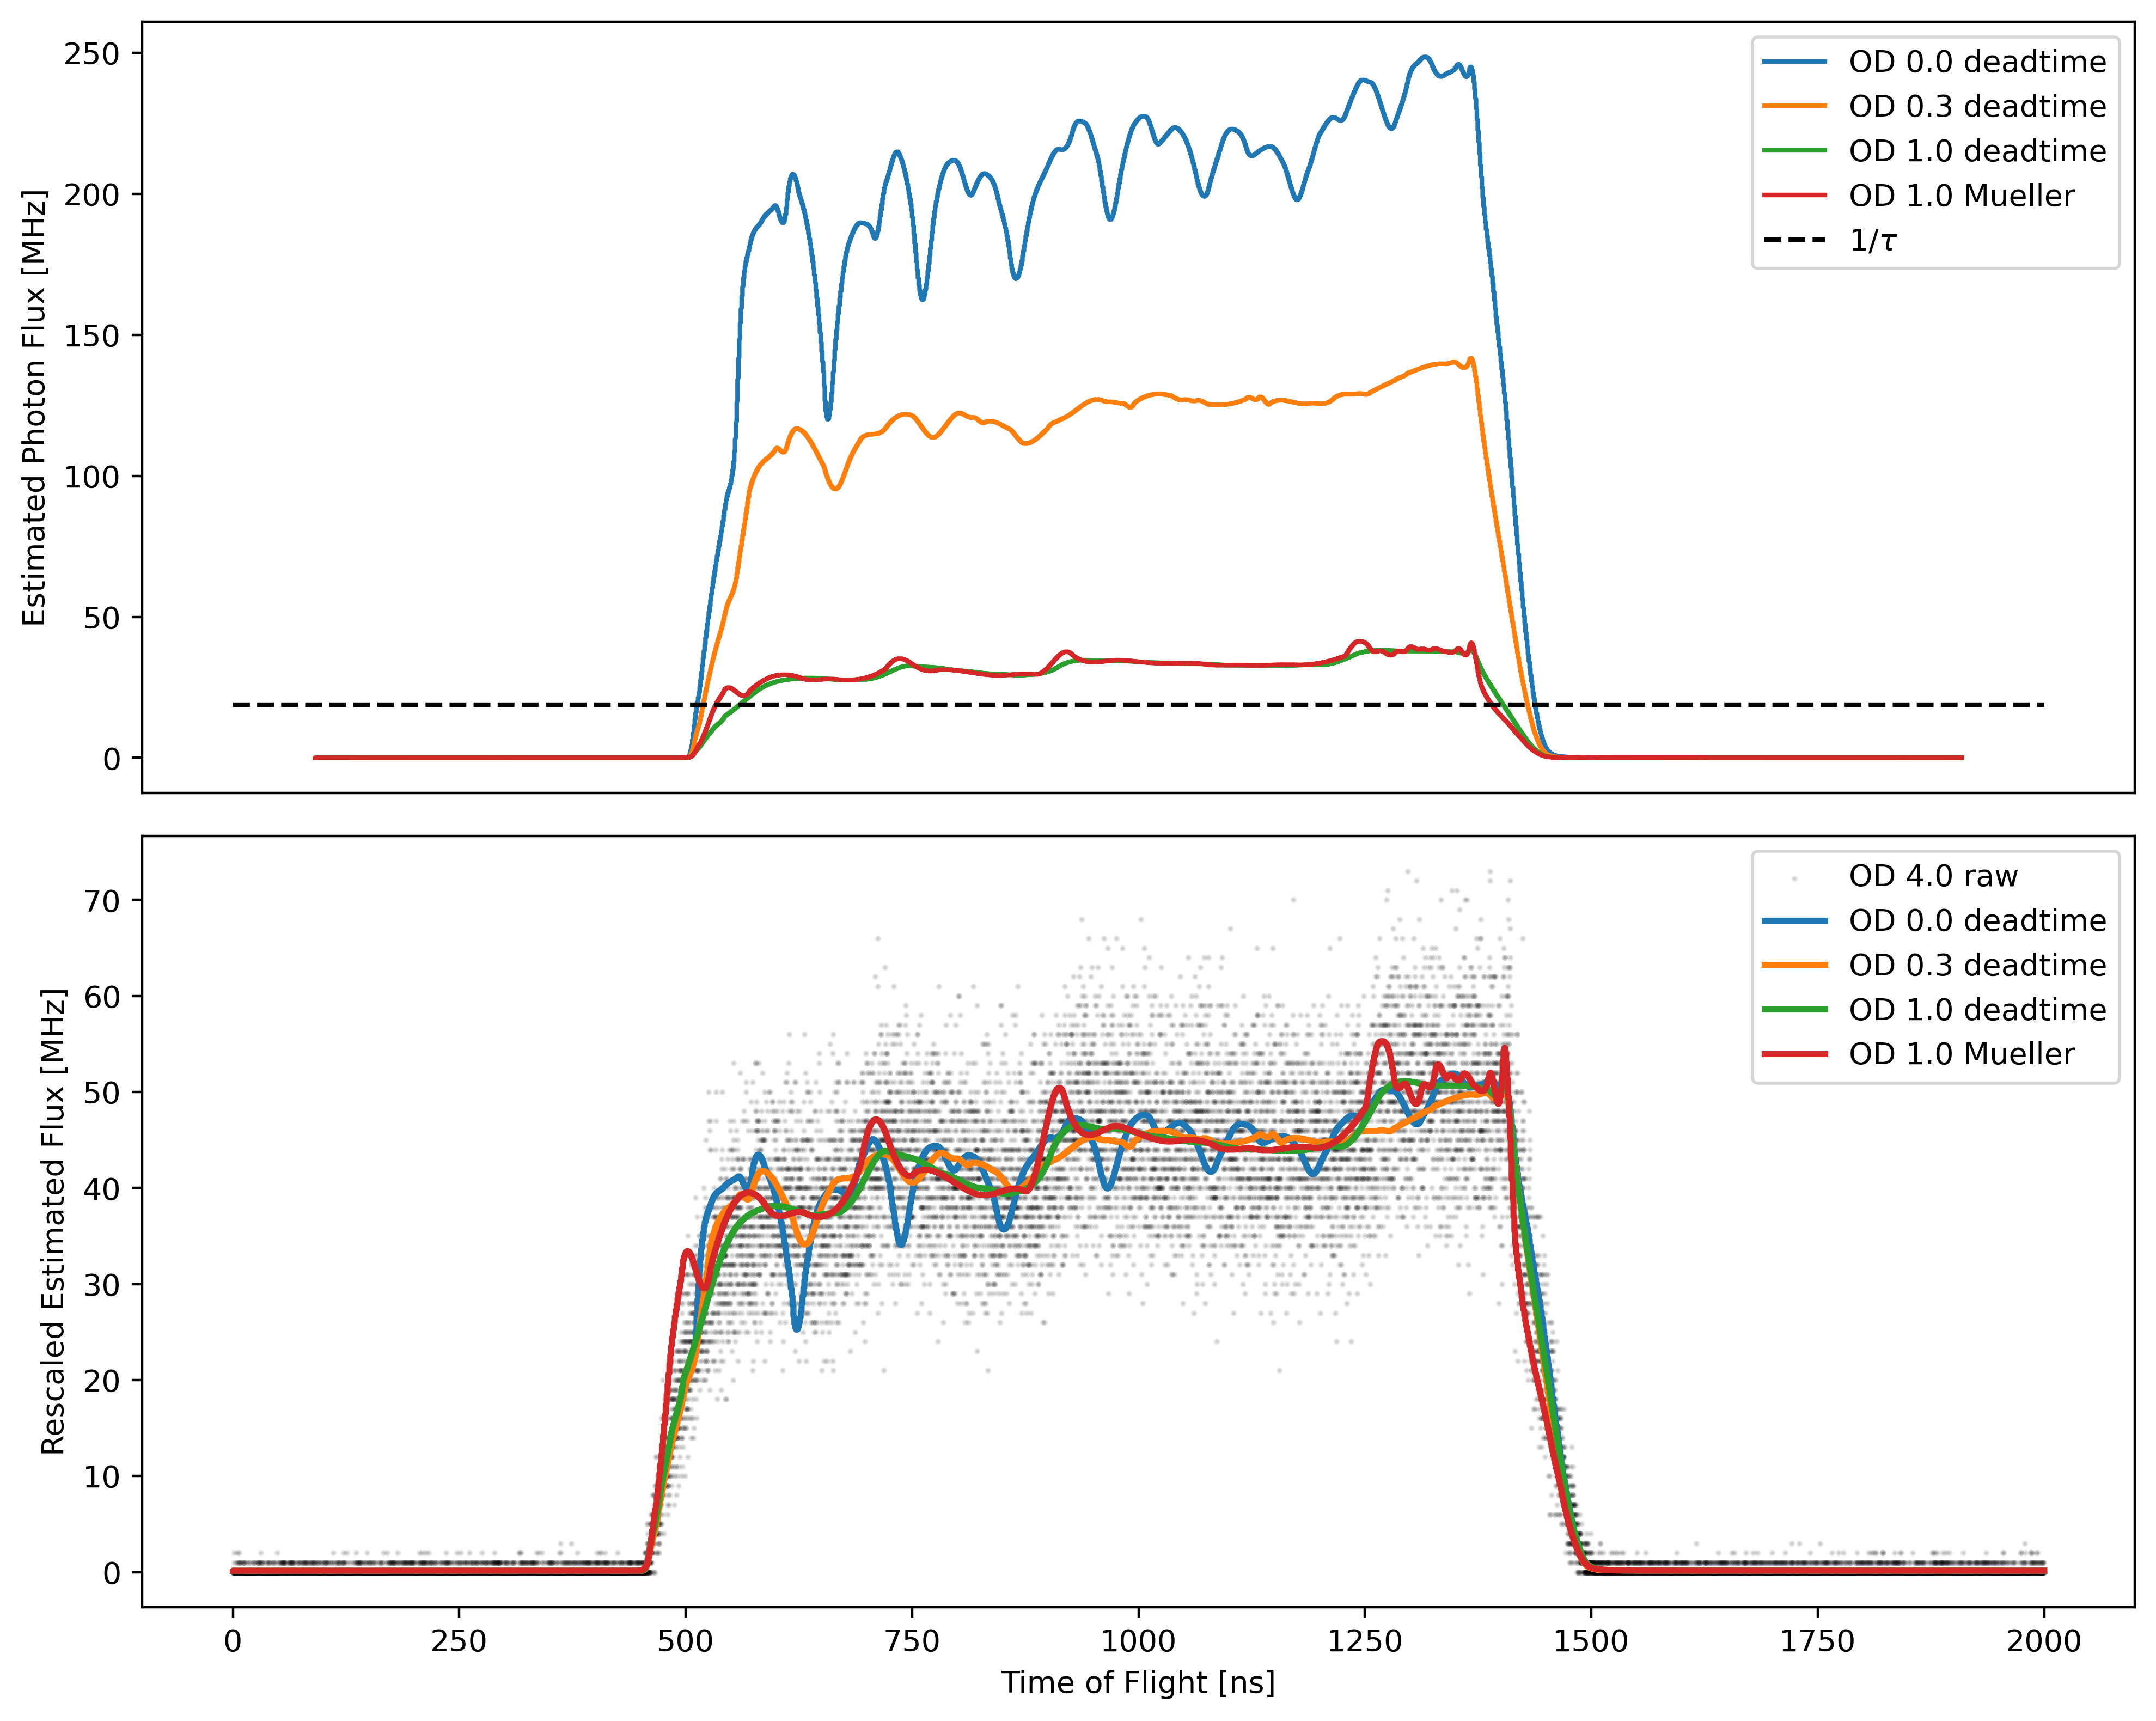

In [36]:
plt_idx_lst = [0,1,2,3,]
eval_OD = 4.0

fig,ax_lst = plt.subplots(2,1,figsize=(10,8), dpi=400)
ax = ax_lst[0]
# plt.scatter(fit_model.r_train.numpy(),y_phot_vld_tnsr.numpy().flatten(),s=1,c='k',alpha=0.2)
for idx in plt_idx_lst:
    ds = sol_ds_lst[idx]
    ax.plot(ds['time_axis'],1e-6*ds['signal'],label=f"OD {ds.attrs['OD']} "+ds.attrs['noise_model'].replace("mueller",'Mueller'))
#     print(np.max(ds['signal'].values*1e-6))

ax.plot(ax.get_xlim(),[1e-6/ds.attrs['deadtime'],1e-6/ds.attrs['deadtime']],'k--',label=r"$1/\tau$")

# # ax.set_yscale('log')
# # ax.set_ylim([1e3,5e7])
# # ax.set_xlabel('Time [$\mu s$]')
ax.set_ylabel("Estimated Photon Flux [MHz]")
ax.set_xticks([])
ax.legend()


ax = ax_lst[1]
# ax.scatter(fit_model.r_train.numpy()*1e3,y_phot_vld_tnsr.numpy().flatten(),s=1,c='k',alpha=0.05)
ax.scatter(ds_raw['time_bin_edges'].values*1e9,ds_raw['y_phot_vld'].sel(OD=eval_OD).values,s=1,c='k',alpha=0.1, label='OD 4.0 raw')
for idx in plt_idx_lst:
    ds = sol_ds_lst[idx]
    if 'mueller' in ds.attrs['noise_model'].lower():
        y_time_int = ds_raw['y_shot_fit'].sel(OD=eval_OD).values*np.median(np.diff(ds_raw['time_bin_edges'].values))
        ax.plot(ds['time_axis'].values,y_time_int*ds['rho_vld'].values,linewidth=2,label=f"OD {ds.attrs['OD']} "+ds.attrs['noise_model'].replace("mueller",'Mueller'))
    else:
        y_active_fit = ds_raw['y_active_fit'].sel(OD=eval_OD).values
        ax.plot(ds['time_axis'].values,(y_active_fit*ds['rho_vld'].values),linewidth=2,label=f"OD {ds.attrs['OD']} "+ds.attrs['noise_model'].replace("mueller",'Mueller'))
ax.legend()
ax.set_xlabel('Time of Flight [ns]')
ax.set_ylabel('Rescaled Estimated Flux [MHz]')

# # plt.plot(fit_model.r_train.numpy(),(y_active_fit_tnsr*rho_vld).detach().numpy().flatten(),color='k')
# ax.set_ylabel("Photon Counts at OD 4.0")
# ax.legend()
plt.tight_layout()
plt.show()

In [7]:
plt_idx_lst = [0,1,2,3,4,5]

deadtime_od_data_lst = []
deadtime_loss_data_lst = []
mueller_od_data_lst = []
mueller_loss_data_lst = []

for idx in plt_idx_lst:
    ds = sol_ds_lst[idx]
    if ds.attrs['noise_model'] == 'deadtime':
        deadtime_od_data_lst.append(ds.attrs['OD'])
        deadtime_loss_data_lst.append(ds.attrs['loss_val'])
    else:
        mueller_od_data_lst.append(ds.attrs['OD'])
        mueller_loss_data_lst.append(ds.attrs['loss_val'])

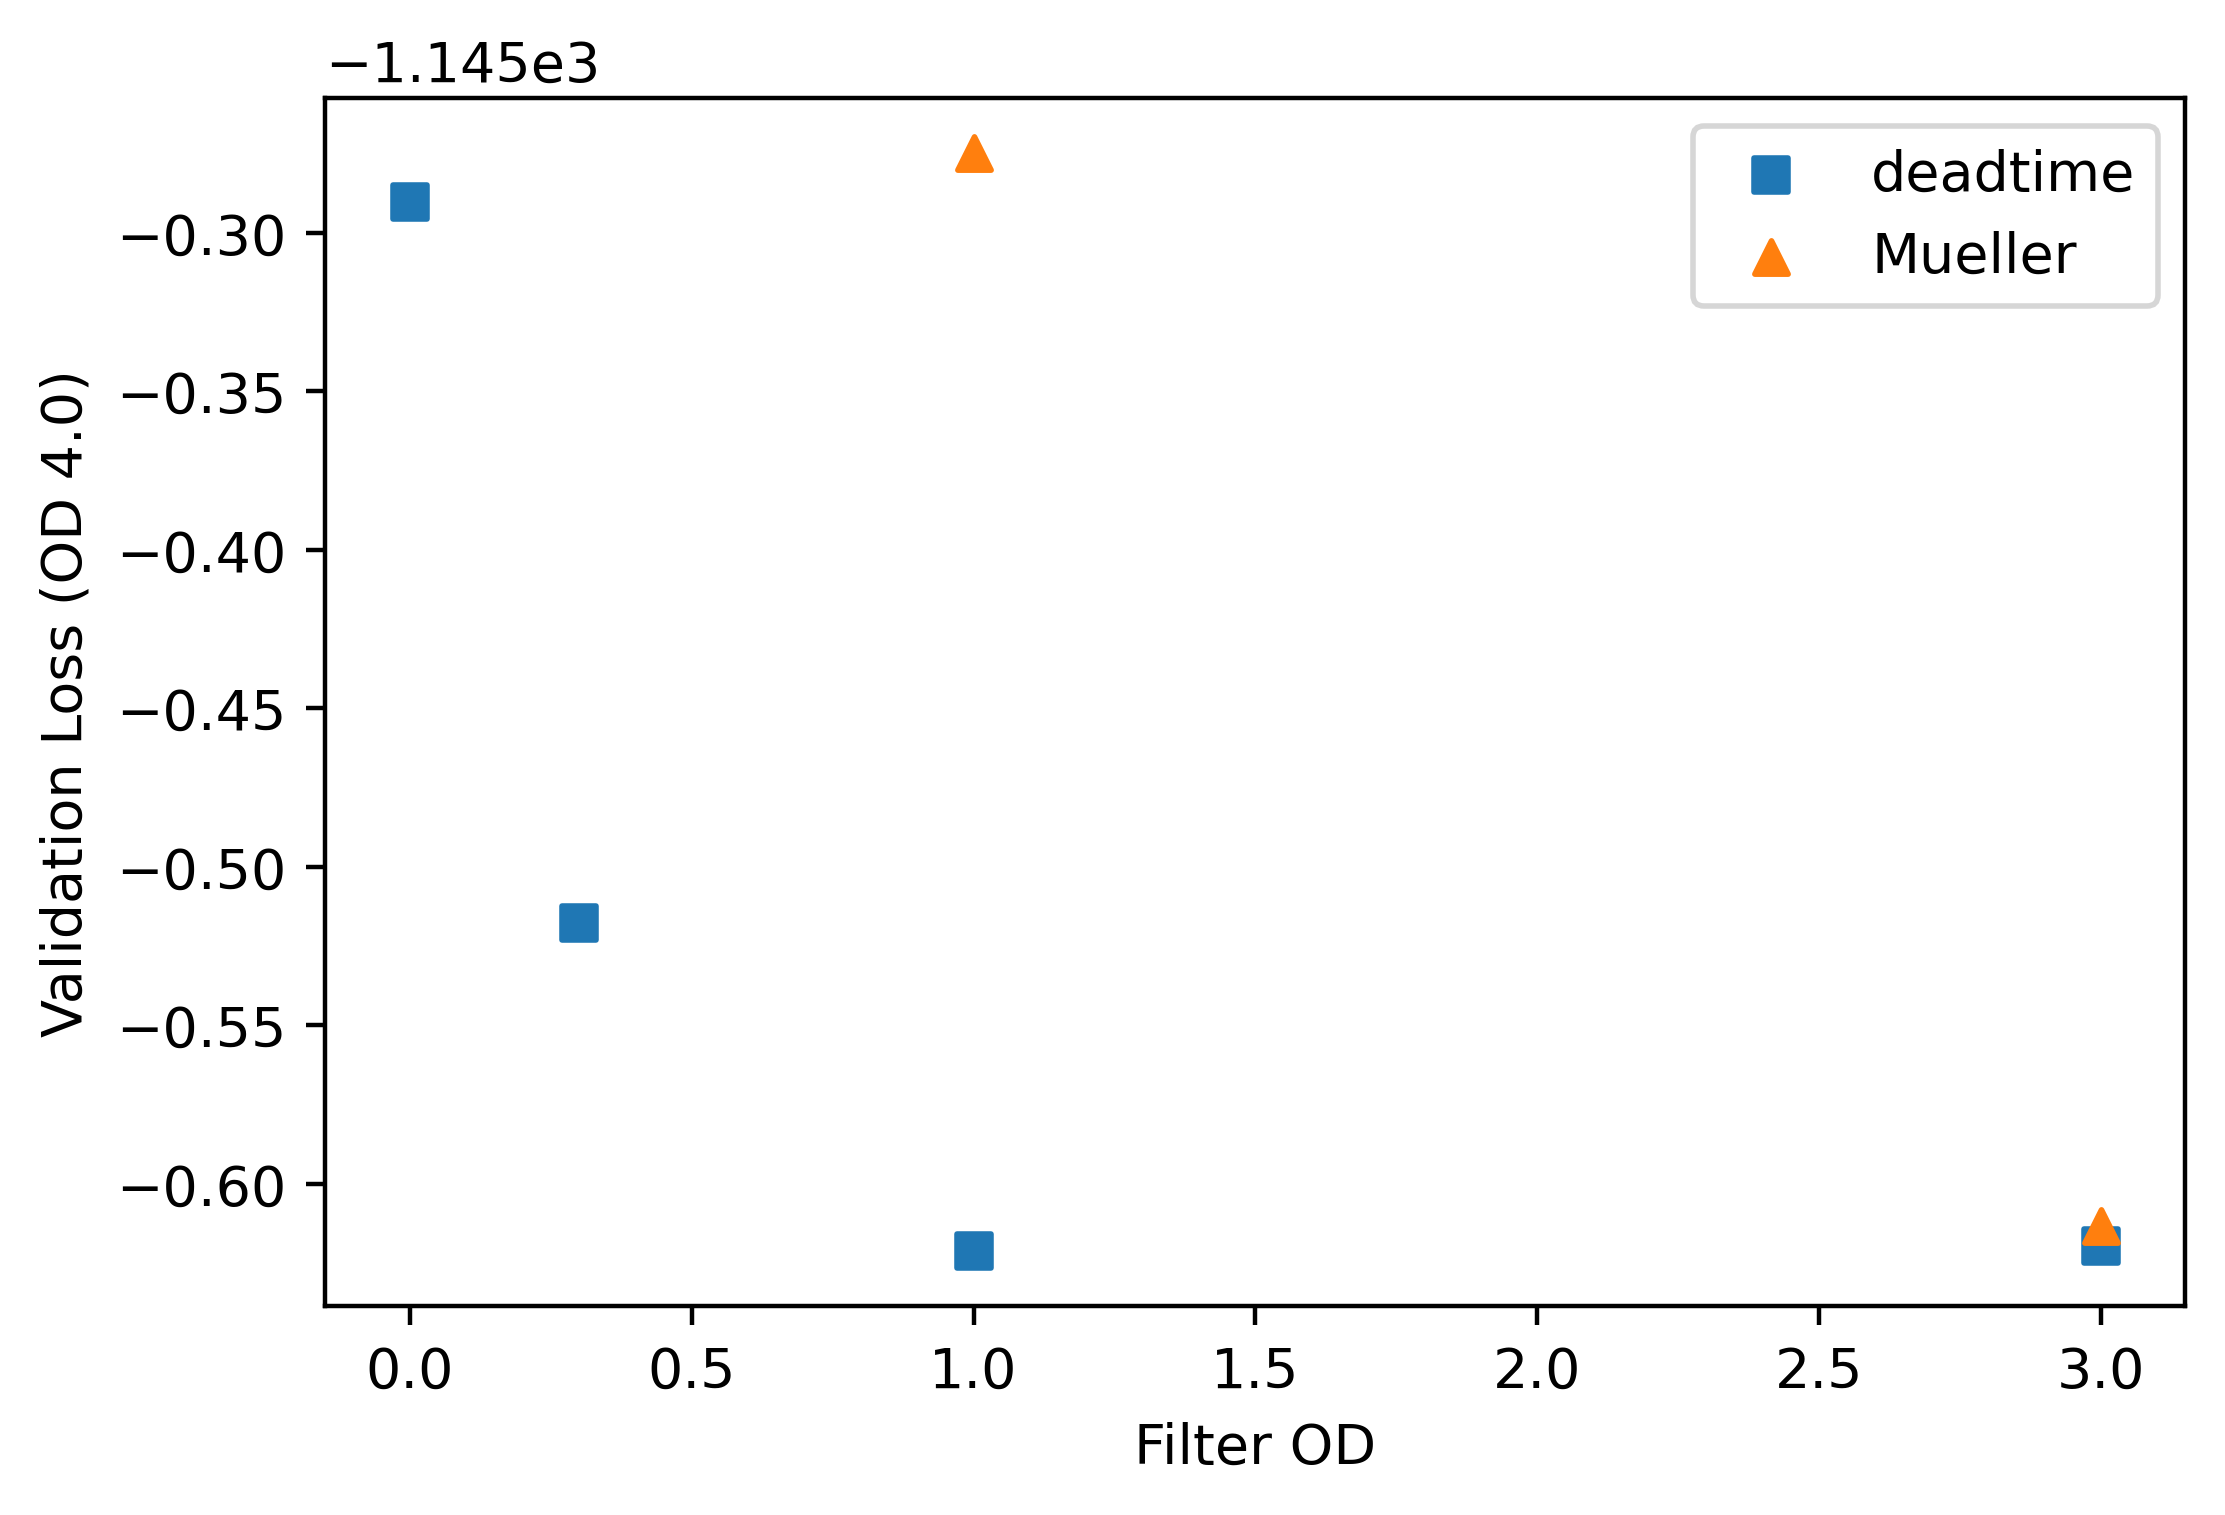

In [37]:
fig,ax = plt.subplots(1,1, dpi=400)

        
ax.scatter(deadtime_od_data_lst,deadtime_loss_data_lst,c='tab:blue', marker='s',label='deadtime')
ax.scatter(mueller_od_data_lst,mueller_loss_data_lst,c='tab:orange', marker='^',label='Mueller')

plt.xlabel("Filter OD")
plt.ylabel("Validation Loss (OD 4.0)")
# plt.grid(visible=True)
plt.legend()